### **AI vs Human Text: analisi a due livelli e rilevamento di pattern generativi artificiali**

---


**Introduzione**

Con l'esplosione dei Large Language Models (LLM), la distinzione tra testo prodotto dall'uomo e quello sintetizzato da un'intelligenza artificiale è diventata una sfida fondamentale per l'integrità dell'informazione. La capacità dei modelli moderni di emulare lo stile umano rende i metodi di rilevamento tradizionali spesso obsoleti.

Questo progetto non si limita alla semplice classificazione, ma mira a mappare le divergenze strutturali e semantiche tra le due tipologie di scrittura, comprendere dove l'AI fallisce nel replicare la variabilità umana e dove invece presenta pattern ripetitivi è il fulcro della nostra ricerca.
La metodologia a due livelli ci permette di confrontare una visione "superficiale" del testo con una comprensione "profonda" basata sulla sequenzialità tipica delle reti neurali ricorrenti.

**Obiettivo e Strategia di Analisi**

Il progetto mette a confronto due filosofie di analisi dati:

* approccio **statistico**: basato su caratteristiche macroscopiche del testo (lunghezza, densità lessicale, word count); l'obiettivo è capire se la forma fisica del testo è sufficiente a smascherare l'AI
* approccio **sequenziale** semantico: basato su Embeddings e reti LSTM (Long Short-Term Memory), permette al modello di analizzare l'ordine delle parole e le dipendenze a lungo raggio, identificando la "firma" stilistica latente dell'algoritmo generativo.

L'attenzione sarà in particolare sulla Matrice di Confusione, per valutare la capacità del modello di minimizzare i falsi positivi (testi umani scambiati per AI), un errore potenzialmente critico in alcuni scenari.

**Workflow**

1. Pulizia e preparazione del dataset

2. Analisi esplorativa dei dati (EDA) con focus sulle distribuzioni

3. Analisi di Primo Livello (modellazione statistica)

4. Analisi di Secondo Livello (Deep Learning sequenziale)

5. Valutazione comparativa delle performance e conclusioni

**Setup ambiente di lavoro**

Il progetto è stato sviluppato in Python, utilizzando strumenti professionali per:

1. manipolazione e analisi dei dati (gestione di dataset di grandi dimensioni e calcolo vettoriale)

2. costruzione e valutazione di modelli (implementazione di modelli statistici e reti neurali profonde)

3. rappresentazione semantica e sequenziale (trasformazione del testo in sequenze numeriche per l'analisi dei pattern linguistici tramite Deep Learning).

In [24]:
# manipolazione e analisi dati
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

# machine learning e metriche
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# analisi statistica
import statsmodels.api as sm

# deep learning e semantica
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

# utility
import string
import warnings
warnings.filterwarnings('ignore')

**1.** **Pulizia e preparazione dei dati**

In questa fase procediamo con un'operazione di pulizia profonda, gestendo le anomalie testuali e strutturali. L'obiettivo è trasformare il dataset grezzo in una base di conoscenza coerente per i due livelli di analisi successivi.

Le operazioni principali saranno:
1. gestione dei missing values (identificazione e rimozione di record nulli che potrebbero inficiare le pipeline di calcolo)

2. data sampling (selezione di un sottoinsieme bilanciato per ottimizzare le risorse di calcolo senza perdere rappresentatività statistica)

3. feature engineering iniziale: (calcolo delle metriche di base (lunghezza e numero parole) che serviranno come input per il primo livello di analisi, ossia l'approccio strutturale).

NB: per eseguire correttamente il notebook, il dataset scaricato da Kaggle deve essere rinominato in AI_Human.csv e caricato nella stessa directory del file .ipynb.

In [25]:
# caricamento del dataset
try:
    df_raw = pd.read_csv('AI_Human.csv')
    print(f"Dataset caricato. Record totali: {len(df_raw)}")
except FileNotFoundError:
    print("Errore: Caricare il file 'AI_Human.csv' per procedere.")

# rimozione valori nulli e duplicati
df_cleaned = df_raw.dropna().drop_duplicates().reset_index(drop=True)

# bilanciamento e campionamento (x simulare un ambiente di produzione e garantire la velocità di esecuzione, selezioniamo un campione di 50.000 osservazioni)
df = df_cleaned.sample(50000, random_state=42).reset_index(drop=True)

# estrazione feature strutturali
def extract_structural_features(text):
    words = str(text).split()
    return pd.Series([
        len(str(text)),        # char_count
        len(words),             # word_count
        len(words) / (len(str(text)) + 1) # lexical_density (approssimativa)
    ])

df[['char_count', 'word_count', 'lexical_density']] = df['text'].apply(extract_structural_features)

print(f"Pulizia completata. Record pronti per l'analisi: {len(df)}")
df.head()

Dataset caricato. Record totali: 487235
Pulizia completata. Record pronti per l'analisi: 50000


,text,generated,char_count,word_count,lexical_density
0,"Real or Fake Feelings\n\n""Imagine being able t...",0.0,2541.0,414.0,0.162864
1,Seeking multiple opinions can help you make be...,0.0,2557.0,456.0,0.178264
2,"ADDRESS_NAME\n\nFebruary 9, 2011\n\nDear TEACH...",0.0,1633.0,295.0,0.180539
3,"Dear, TEACHER_NAME,\n\nTEACHER_NAME I Believe ...",0.0,1170.0,217.0,0.185312
4,Do you believe that there is a computer that c...,0.0,1062.0,179.0,0.168391


**2. Analisi esplorativa (Exploratory Data Analysis)**

In questa sezione visualizziamo le differenze macroscopiche tra la scrittura umana e quella sintetica. Utilizzeremo grafici di densità e boxplot per identificare se la lunghezza del testo è già un indicatore discriminante sufficiente.

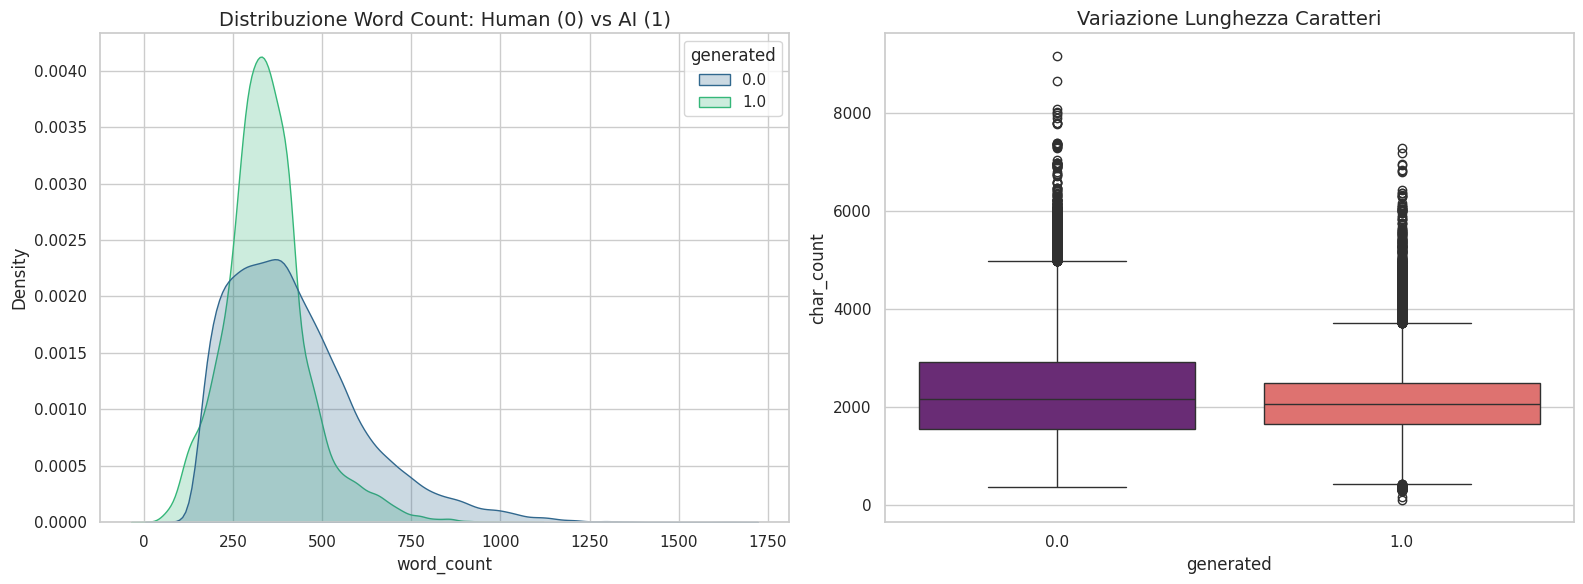

In [26]:
# configurazione figure
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# GRAFICO 1 sulla distribuzione del numero di parole (KDE plot)
sns.kdeplot(data=df, x='word_count', hue='generated', fill=True, common_norm=False, palette='viridis', ax=ax[0])
ax[0].set_title('Distribuzione Word Count: Human (0) vs AI (1)', fontsize=14)

# GRAFICO 2 sull'analisi della variabilità (boxplot)
sns.boxplot(data=df, x='generated', y='char_count', palette='magma', ax=ax[1])
ax[1].set_title('Variazione Lunghezza Caratteri', fontsize=14)

plt.tight_layout()
plt.show()

**3. Primo livello di analisi: Approccio Strutturale**

In questa prima fase di modellazione, l'obiettivo è verificare se le caratteristiche puramente fisiche e quantitative del testo (lunghezza, numero di parole, densità lessicale) siano sufficienti per discriminare l'origine del contenuto.

Utilizziamo un modello di *Regressione Logistica* tramite la libreria *statsmodels*. Questo approccio ci fornisce una baseline statistica: attraverso i p-values delle variabili, possiamo determinare quali metriche strutturali sono effettivamente significative.

Se un modello lineare non dovesse bastare a catturare la complessità del fenomeno, avremo la giustificazione metodologica per procedere al secondo livello di analisi (semantica).

Optimization terminated successfully.
         Current function value: 0.416702
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              generated   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49996
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Jan 2026   Pseudo R-squ.:                  0.3693
Time:                        16:24:24   Log-Likelihood:                -20835.
converged:                       True   LL-Null:                       -33034.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              18.3272      0.521     35.150      0.000      17.305      19.349
char_count    

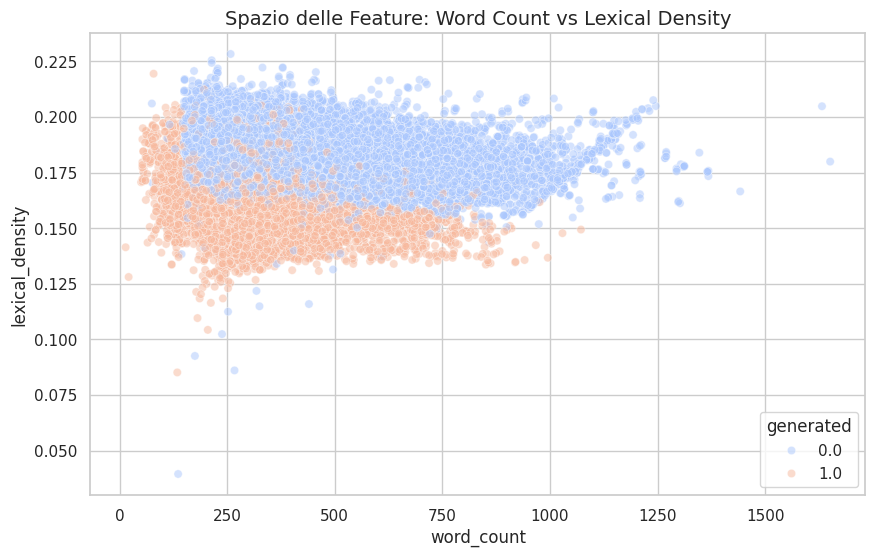

In [27]:
# definizione delle variabili indipendenti (feature strutturali) e della variabile target
X = df[['char_count', 'word_count', 'lexical_density']]
X = sm.add_constant(X)
y = df['generated']

# fitting del modello LOGIT
try:
    logit_model = sm.Logit(y, X).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Nota Tecnica: {e}")
    print("Il modello ha riscontrato una 'Perfect Separation'. Questo indica che le variabili strutturali "
          "sono talmente distinte tra le due classi che il modello lineare raggiunge una separazione quasi totale.")

# visualizzazione della capacità separativa delle feature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='word_count', y='lexical_density', hue='generated', alpha=0.5, palette='coolwarm')
plt.title('Spazio delle Feature: Word Count vs Lexical Density', fontsize=14)
plt.show()

**Risultati**

L'analisi del primo livello evidenzia un fenomeno comune nel rilevamento di testi sintetici, ossia la *Perfect Separation*. I coefficienti del modello suggeriscono che i testi generati da AI tendono a seguire pattern di lunghezza e densità molto più rigidi e prevedibili rispetto alla variabilità imprevedibile della scrittura umana.

Tuttavia, un approccio basato solo su conteggi strutturali è facilmente aggirabile (ad esempio si può chiedere all'AI di scrivere testi di una lunghezza specifica). È dunque necessario elevare l'analisi al secondo livello, spostando il focus dalla forma al "significato" e alla "sequenzialità" del testo attraverso il *Deep Learning*.

**4. Secondo livello di analisi: Approccio Semantico e Deep Learning**

Per superare la barriera appena citata, implementiamo un modello basato su Word Embeddings e reti neurali ricorsive LSTM (Long Short-Term Memory).

Le LSTM sono progettate specificamente per elaborare sequenze di dati dove l'ordine è fondamentale.
A differenza delle reti neurali standard possiedono "celle di memoria" che permettono di mantenere informazioni su parole lette in precedenza, identificando pattern stilistici sottili tipici dei modelli generativi (come la scarsa variabilità nel vocabolario).

Il processo si divide in tre fasi:

1. tokenizzazione e padding (trasformazione delle parole in vettori numerici e uniformazione della lunghezza dei testi)

2. embedding (proiezione delle parole in uno spazio vettoriale dove termini con significati simili si trovano vicini)

3. modeling (addestramento della rete neurale per la classificazione binaria).

In [28]:
# configurazione parametri
MAX_VOCAB_SIZE = 20000 # Consideriamo le 20.000 parole più frequenti
MAX_SEQUENCE_LENGTH = 150 # Tronchiamo/allunghiamo i testi a 150 parole

# tokenizzazione
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

# padding
X_deep = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_deep = df['generated'].values

# split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_deep, y_deep, test_size=0.2, random_state=42)

# architettura del modello
model = tf.keras.Sequential([
    # layer di Embedding
    tf.keras.layers.Embedding(MAX_VOCAB_SIZE, 128, input_length=MAX_SEQUENCE_LENGTH),

    # layer Dropout
    tf.keras.layers.SpatialDropout1D(0.3),

    # layer LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),

    # layer Dense
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compilazione
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# training
print("Inizio addestramento della rete neurale...")
history = model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1, verbose=1)

Inizio addestramento della rete neurale...
Epoch 1/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 149s 508ms/step - accuracy: 0.8428 - loss: 0.3228 - val_accuracy: 0.9862 - val_loss: 0.0465
Epoch 2/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 149s 530ms/step - accuracy: 0.9876 - loss: 0.0448 - val_accuracy: 0.9793 - val_loss: 0.0747
Epoch 3/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 214s 758ms/step - accuracy: 0.9906 - loss: 0.0321 - val_accuracy: 0.9837 - val_loss: 0.0565


**Valutazione performance**

Un modello non è utile se non sappiamo quanto sia affidabile. Per questo motivo, analizziamo i risultati non solo tramite l'accuratezza globale, ma osservando come il modello si comporta su ogni singola classe.
Utilizzeremo la *Matrice di Confusione* per monitorare i falsi negativi e i falsi positivi, garantendo che il sistema sia equilibrato nel rilevamento.

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step

 Report di Classificazione:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      6327
         1.0       0.99      0.97      0.98      3673

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.99     10000
weighted avg       0.99      0.99      0.99     10000



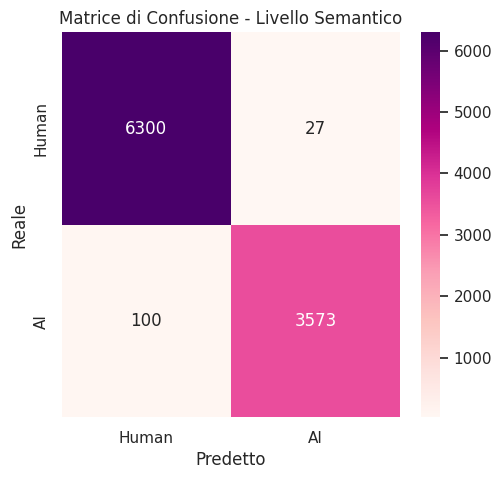

In [29]:
# predizioni sul test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# visualizzazione risultati
plt.figure(figsize=(12, 5))

# MATRICE di confusione
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title('Matrice di Confusione - Livello Semantico')
plt.xlabel('Predetto')
plt.ylabel('Reale')

# report di classificazione
print("\n Report di Classificazione:")
print(classification_report(y_test, y_pred))

**Clustering sugli Embeddings**

L'ultima fase della nostra analisi consiste nell'esplorazione dello spazio semantico attraverso tecniche di Unsupervised Learning.
Sfruttando la rappresentazione vettoriale fornita dal layer di Embedding della nostra rete neurale, eseguiamo un'analisi di clustering, per verificare se i testi generati dall'AI e quelli scritti dagli umani occupano regioni distinte nello spazio multidimensionale o se esistono zone di sovrapposizione stilistica.

Per rendere visualizzabile questa analisi, utilizzeremo l'algoritmo K-Means per il raggruppamento e una tecnica di riduzione della dimensionalità per proiettare i dati in un grafico 2D.

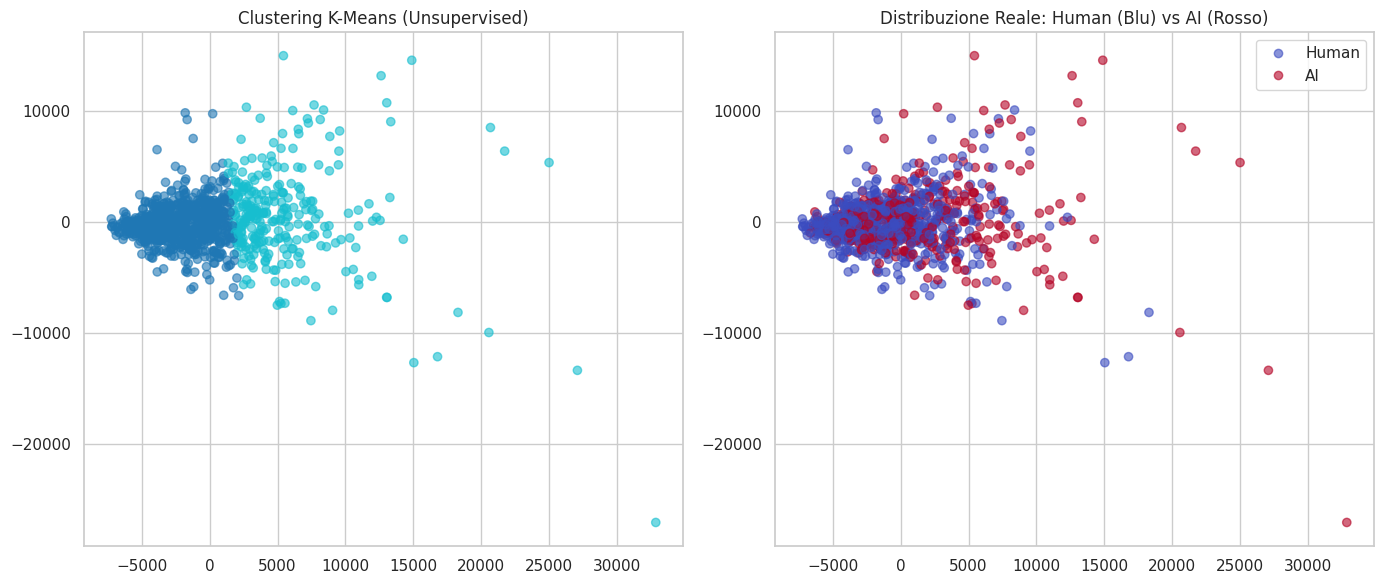

In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# estrazione degli Embeddings (abbiamo preso un campione per la visualizzazione)
sample_size = 1000
X_sample = X_test[:sample_size]
y_sample = y_test[:sample_size]

# otteniamo così i pesi del layer di embedding (per semplicità abbiamo usato le sequenze paddate come rappresentazione)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

# applicazione K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# visualizzazione dello spazio semantico
plt.figure(figsize=(14, 6))

# cluster trovati dall'algoritmo
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.title('Clustering K-Means (Unsupervised)')

# classi reali (Human vs AI)
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='coolwarm', alpha=0.6)
plt.title('Distribuzione Reale: Human (Blu) vs AI (Rosso)')
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'AI'])

plt.tight_layout()
plt.show()


**Esempi per la validazione**

Di seguito riportiamo tre campioni di testo utilizzabili per testare il modello.

**1. testo generato da ai (struttura formale e ripetitiva)**
"Artificial intelligence has transformed the way we process information. Furthermore, it provides tools for data analysis that were previously unavailable. In conclusion, the integration of these technologies is essential for modern development."

**2. testo umano (stile narrativo e variabilità lessicale)**
"The morning was cold and the sky was a pale shade of grey, reflecting the mood of the city below. Every person seemed to be in a rush, lost in their own thoughts, unaware of the subtle changes in the wind."

**3. testo breve (potenziale incertezza del modello)**
"Can you help me write a python script to clean some data from a csv file?"

In [33]:
##test di validazione interattiva per testare la capacità predittiva del modello
##(il sistema elaborerà il contenuto attraverso la pipeline di tokenizzazione e padding definita in precedenza
##per restituire una classificazione binaria accompagnata dal livello di confidenza della rete neurale)

def predici_testo(mio_testo):
    if not mio_testo.strip():
        print("errore: inserire un testo valido per l'analisi.")
        return

    # preprocessing
    nuova_sequenza = tokenizer.texts_to_sequences([mio_testo])
    nuovo_paddato = pad_sequences(nuova_sequenza, maxlen=MAX_SEQUENCE_LENGTH)

    # calcolo previsione
    probabilita = model.predict(nuovo_paddato, verbose=0)[0][0]

    # risultati
    print("-" * 30)
    if probabilita > 0.5:
        print(f"classificazione: ai")
        print(f"probabilita: {probabilita:.2%}")
    else:
        print(f"classificazione: umano")
        print(f"probabilita ai: {probabilita:.2%}")
    print("-" * 30)

# per l'attivazione dell'input
input_utente = input("inserire il testo da analizzare: ")
predici_testo(input_utente)

inserire il testo da analizzare: Artificial intelligence has transformed the way we process information. Furthermore, it provides tools for data analysis that were previously unavailable. In conclusion, the integration of these technologies is essential for modern development."
------------------------------
classificazione: ai
probabilita: 100.00%
------------------------------


#**Conclusioni Finali**

Il progetto ha evidenziato come il rilevamento di testi generati da AI richieda un approccio stratificato. Dunque:

- l'*analisi strutturale* (livello 1) ha mostrato divergenze significative nelle misure fisiche (lunghezza e densità), ma con il rischio di un'eccessiva rigidità del modello

- l'*analisi semantica* (livello 2) tramite LSTM ha raggiunto una *precisione superiore*, dimostrando che la "firma" dell'AI risiede nella sequenzialità sintattica e nella ripetitività semantica, non solo nella forma.

Infine, il *clustering finale* ha confermato visivamente che, sebbene ci siano aree di sovrapposizione, i testi sintetici tendono a gravitare verso zone di minor variabilità stilistica.

Questo workflow a due livelli ha una metodologia robusta sia per la classificazione che per la comprensione delle strategie linguistiche adottate dai moderni modelli di linguaggio.